# _C. elegans_ low dimensional activity modeled by a nonlinear dynamical system with control

_C. elegans_ neural activity and its relation to behavior is difficult to characterize as both the dynamics and control are nonlinear. We propose a minimally parameterized nonlinear control model that can be fit to have the same features as those observed in the neural activity data. Nonlinear interpretable models such as this may give us insight into _C. elegans_ dynamics in ways that linear models are unable to due to the intrinsic nonlinearities in the system.

This notebook reproduces select results from the paper "Neuro-sensory integration in the nematode _C. elegans_ as a nonlinear dynamical system with control". More specifically, we implement PCA on the neural activity of a single _C. elegans_ and generate a nonlinear control model with tunable parameters that emulates the _C. elegans_ low dimensional activity.  We compare the state distributions of the data and model and quanitify goodness of fit of the model to the data by calculating the Kullback–Leibler divergence between the probability distribution functions.


## Table of contents
1. [_C. elegans_ dimensionality reduction](#Celegans)
2. [Nonlinear control model](#nonlin_control)
3. [Compare distributions](#compare_dist)


In [956]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import numpy as np
import os
import scipy.io as spio
import sdeint  # SDE integrator
from scipy.stats.kde import gaussian_kde
from scipy.signal import find_peaks

#directory = os.getcwd()
#print("Current working directory:", directory)

## _C. elegans_ dimensionality reduction <a name="Celegans"></a>

### Function to load data in matlab files

In [148]:
def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)  #False, True
    return _check_keys(data)

def _check_keys(dict):
    '''
    checks if entries in dictionary are mat-objects. If yes
    todict is called to change them to nested dictionaries
    '''
    for key in dict:
        if isinstance(dict[key], spio.matlab.mio5_params.mat_struct):
            dict[key] = _todict(dict[key])
    return dict        

def _todict(matobj):
    '''
    A recursive function which constructs from matobjects nested dictionaries
    '''
    dict = {}
    for strg in matobj._fieldnames:
        elem = matobj.__dict__[strg]
        if isinstance(elem, spio.matlab.mio5_params.mat_struct):
            dict[strg] = _todict(elem)
        else:
            dict[strg] = elem
    return dict

### Load _C. elegans_ data

In [181]:
file = 'celegan_data'
celegan_data = loadmat('celegan_data.mat')
sevenStateColoring = loadmat('sevenStateColoring.mat')
sevenStateColoring_dataset = scipy.io.loadmat('sevenStateColoring_dataset.mat')

sevenStateColor = sevenStateColoring['sevenStateColoring']
colors = sevenStateColor['colorMap']
state_timeseries = sevenStateColoring_dataset['dataset2'][0][0][0][0]

### Retrieve calcium imaging timeseries

In [211]:
wbData = celegan_data['wbData']
mat = np.transpose(wbData['deltaFOverF'])

# 129 neurons, and 3021 timepoints
mat.shape

(129, 3021)

### PCA on neuron activity timeseries

In [46]:
# Center data
avg = np.mean(mat, axis=1)  
mat = mat-avg.reshape((-1,1))

# PCA
u, s, vh = np.linalg.svd(mat, full_matrices=False)

### Plot the _C. elegans_ trajectories in PCA space

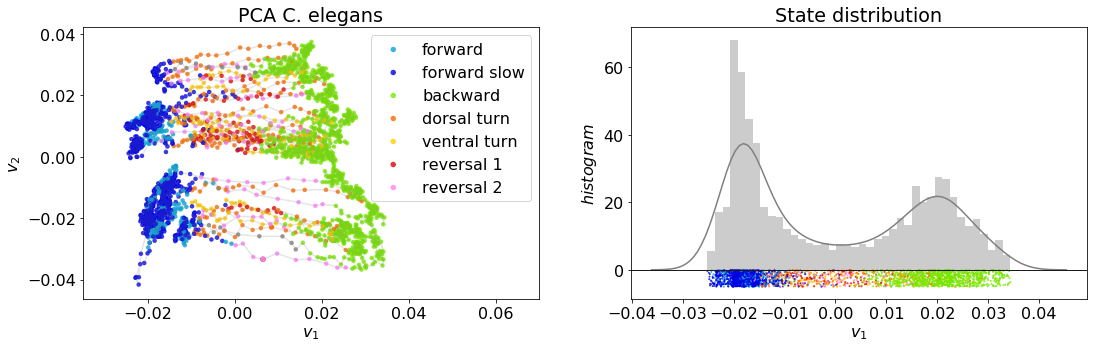

In [960]:
# Create plot

font = {'family' : 'normal',
        'size'   : 16}
matplotlib.rc('font', **font)

fig, ax = plt.subplots(1, 2, sharey=False,figsize=(18,5))

c = colors[state_timeseries-1,:]
ax[0].scatter(vh[0,90], vh[1,90], alpha=0.8, c=c[90,:].reshape((1,-1)), s=30, label = 'forward', edgecolors='none')
ax[0].scatter(vh[0,0], vh[1,0], alpha=0.8, c=c[0,:].reshape((1,-1)), s=30, label = 'forward slow', edgecolors='none')
ax[0].scatter(vh[0,400], vh[1,400], alpha=0.8, c=c[400,:].reshape((1,-1)), s=30,label = 'backward', edgecolors='none')
ax[0].scatter(vh[0,70], vh[1,70], alpha=0.8, c=c[70,:].reshape((1,-1)), s=30, label = 'dorsal turn', edgecolors='none')
ax[0].scatter(vh[0,170], vh[1,170], alpha=0.8, c=c[260,:].reshape((1,-1)), s=30, label = 'ventral turn', edgecolors='none')
ax[0].scatter(vh[0,170], vh[1,170], alpha=0.8, c=c[280,:].reshape((1,-1)), s=30, label = 'reversal 1', edgecolors='none')
ax[0].scatter(vh[0,170], vh[1,170], alpha=0.8, c=c[170,:].reshape((1,-1)), s=30, label = 'reversal 2', edgecolors='none')

ax[0].plot(vh[0,:], vh[1,:], alpha = 0.2, c=[0.5, 0.5, 0.5])
ax[0].scatter(vh[0,:], vh[1,:], alpha=0.8, c=c, s=20, edgecolors='none')
ax[0].set_xlabel('$v_1$')
ax[0].set_ylabel('$v_2$')
ax[0].set_title('PCA C. elegans')
ax[0].set_xlim([-0.035, 0.07])

ax[0].legend()

ax[1].scatter(vh[0,:], -5*np.random.rand(len(vh[0,:])), alpha=0.8, c=c, s=4, edgecolors='none')
sns.distplot(vh[0,:],bins=40,color="grey");

ax[1].set_xlabel('$v_1$')
ax[1].set_ylabel('$histogram$');
ax[1].set_title('State distribution');
xwidth = ax[1].get_xlim()
ax[1].plot(xwidth,[0,0],color=[0.1,0.1,0.1], linewidth=1)
ax[1].set_xlim(xwidth);

## Nonlinear control model <a name="nonlin_control"></a>

In [937]:
#################################
##### set parameters ############
#################################
beta = 0.05     # fixed point stability, # beta = 0.1
gamma = -0.8   # damping term, # gamma = -1
sigma = 0.1  # stochasticity, # sigma = 0.2
omega = 0.1  # average control signal frequency, # omega = 0.1
dur = 2      # average control signal duration, # dur = 2

######################################################################
##### define dynamical system with and without control signals #######
######################################################################
def f_default(x, t):
    return np.array([x[1], -1*(x[0]+1)*(x[0]-beta)*(x[0]-1) + gamma*x[1]])

def f_control_forward(x, t):
    return np.array([x[1], -1*(x[0]+1)*(x[0]-beta)*(x[0]-1) + gamma*x[1] +1])

def f_control_backward(x, t):
    return np.array([x[1], -1*(x[0]+1)*(x[0]-beta)*(x[0]-1) + gamma*x[1] -1])

def G(x, t):
    return np.diag([sigma, sigma]) # diagonal, so independent driving Wiener processes

In [950]:
#######################################################
### randomly generate control signals #################
#######################################################
num_switches = 20 #20
fp_times = (1/omega+(0.25/omega)*np.random.randn(num_switches,1));
switch_times = np.cumsum(fp_times);

vals = np.zeros(num_switches)
for i in range(num_switches):
    vals[i] = 2*np.random.randint(0,2)-1

In [951]:
##########################################
#### simulate dynamics ###################
##########################################
x0 = np.random.randn(2)
dt = 0.01

result_all = np.empty((0,2))

for i in range(num_switches-1):
    
    ####################################################
    ### generate trajectory under the control signal ###
    ####################################################
    
    control_sig_duration = dur + 0.5*dur*np.random.rand(1)
    tspan_control = np.arange(switch_times[i],switch_times[i]+control_sig_duration,dt)
    
    if vals[i]>0:
        result_control = sdeint.itoint(f_control_forward, G, x0, tspan_control)
    else:
        result_control = sdeint.itoint(f_control_backward, G, x0, tspan)
        
    result_all = np.append(result_all, result_control, axis = 0)
    x0 = result_control[-1,:]
    
    ####################################################################
    ### generate trajectory under default system (no control signal) ###
    ####################################################################
    
    tspan = np.arange(switch_times[i]+control_sig_duration,switch_times[i+1],dt)
    
    result = sdeint.itoint(f_default, G, x0, tspan)
    
    result_all = np.append(result_all, result, axis = 0)
    
    x0 = result[-1,:]

### Plot control model trajectory and histogram

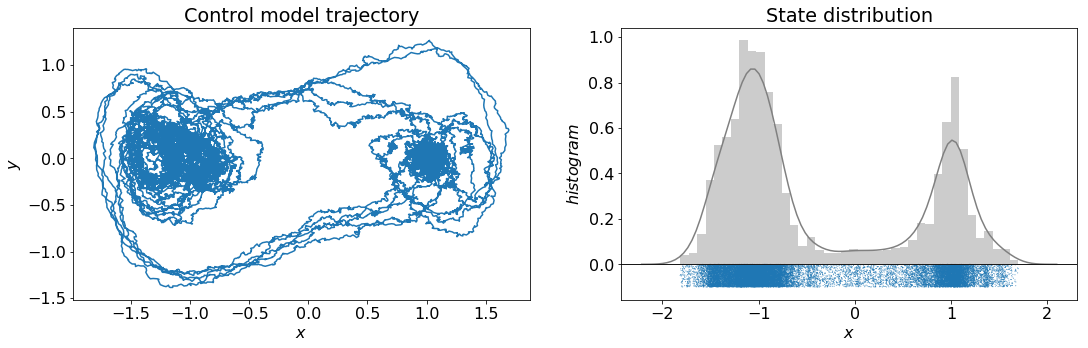

In [952]:
# Create plot
font = {'family' : 'normal',
        'size'   : 16}
matplotlib.rc('font', **font)

fig, ax = plt.subplots(1, 2, sharey=False,figsize=(18,5))

ax[0].plot(result_all[:,0],result_all[:,1])
ax[0].set_xlabel('$x$')
ax[0].set_ylabel('$y$')
ax[0].set_title('Control model trajectory')

ax[1]
sns.distplot(result_all[:,0],bins=40,color="grey");

ax[1].scatter(result_all[:,0],-0.1*np.random.rand(len(result_all)), alpha = 0.8, s=1, edgecolors='none')
#ax[1].hist(result_all[:,0],bins=40);
ax[1].set_xlabel('$x$')
ax[1].set_ylabel('$histogram$');
ax[1].set_title('State distribution');
xwidth = ax[1].get_xlim()
ax[1].plot(xwidth,[0,0],color=[0.1,0.1,0.1], linewidth=1)
ax[1].set_xlim(xwidth);

## Compare distributions <a name="compare_dist"></a>

In [953]:
##########################################################################################
### rescale C. elegans distribution to match the scale of the model's distribution #######
##########################################################################################
x = result_all[:,0]
v1 = vh[0,:]

## find dist between model guassians
KDEpdf_model = gaussian_kde(x)
x_plot = x_plot = np.linspace(-3,3,10000)
x_pdf = KDEpdf_model(x_plot)
peaks_x, _ =find_peaks(x_pdf, height=0)

dist_x = x_plot[peaks_x[-1]]-x_plot[peaks_x[0]]

## rescale the PCA C. elegans distribution - align the guassians to the model guassians
KDEpdf_data = gaussian_kde(v1)
v1_plot = np.linspace(-0.1,0.1,1000)
v1_pdf_tmp = KDEpdf_data(v1_plot)
peaks, _ = find_peaks(v1_pdf_tmp, height=0)
stretch = v1_plot[peaks[-1]]-v1_plot[peaks[0]]
v1 = (dist_x/stretch)*v1
KDEpdf_data = gaussian_kde(v1)

v1_pdf = KDEpdf_data(x_plot)
peaks, _ = find_peaks(v1_pdf, height=0)

diff = x_plot[peaks_x[0]] - x_plot[peaks[0]]

v1 = v1+diff
KDEpdf_data = gaussian_kde(v1)
v1_pdf = KDEpdf_data(x_plot)
peaks, _ = find_peaks(v1_pdf, height=0)

In [954]:
#########################################################################################
## compute KL divergence between the pdfs of the model data and C. elegans data #########
#########################################################################################

KL = 0;
for i in range(len(x_plot)):
    Px = v1_pdf[i]
    Qx = x_pdf[i]
    KL += Px*np.log(Px/Qx)
   
print('KL = ', KL)

KL =  264.60650142393604


### Overlay distributions

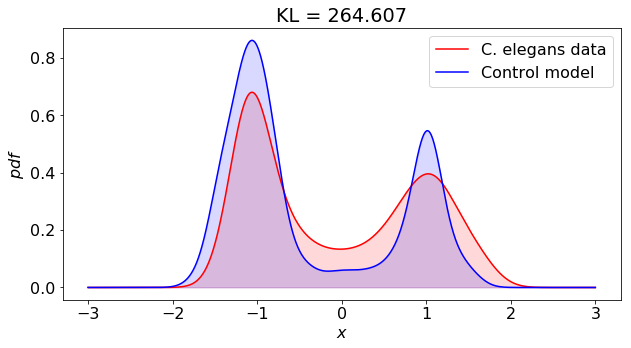

In [955]:
fig, ax = plt.subplots(sharey=False,figsize=(10,5))

ax.plot(x_plot,v1_pdf,'r',label="C. elegans data",color="red")
ax.plot(x_plot,x_pdf,'r',label="Control model",color="blue")

ax.fill_between(x_plot,v1_pdf, color="red", alpha=0.15)
ax.fill_between(x_plot,x_pdf, color="blue", alpha=0.15)
ax.set_title('KL = ' + str(round(KL,3)))
ax.set_xlabel('$x$')
ax.set_ylabel('$pdf$')

ax.legend();